# MLND Capstone - MountainCar DQN Agent
### Mary Troiani
### Imports
See the README.md for specific library versions used. 

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import deque
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras import optimizers

Using TensorFlow backend.


# Required Classes
### Experience Replay
The experience replay is a buffer the collects the (state, action, reward, state1, done) tuples used to train the neural network. It includes two methods: add, to add an additional tuple to the collection, and sample, to randomly select items for training. The deque used in this buffer adds items up to the size limit, then removes old items following a first-in-first-out scheme to make room for the new item. 

In [2]:
class Replay_Buffer:
    def __init__(self, size = 50000):
        self.buffer = deque(maxlen=size)
        
    def add(self, item):
        self.buffer.append(item)
    
    def sample(self, sample_size):
        choices = np.random.choice(len(self.buffer),size=sample_size,replace=False)
        return [self.buffer[x] for x in choices]

### DDQN Model
This class contains both agents used in the double deep Q network scheme - the model and the target model. These networks have an identical structure when created using makeModel. The updateTarget function passes the weights from the training model to the target model (making the two models identical again). The getAction function is a predict function that returns the optimal action that the trained model chooses. 

In [3]:
class Agent:
    def __init__(self, lr, h_size, s_size=2, a_size=3):
        self.model = self.makeModel(lr, h_size, s_size, a_size)
        self.target_model = self.makeModel(lr, h_size, s_size, a_size)
        
    def makeModel(self, lr, h_size, s_size, a_size):
        model = Sequential()
        model.add(Dense(h_size, input_dim=2, activation='relu'))
        model.add(Dense(h_size, activation='relu'))
        model.add(Dense(h_size, activation='relu'))
        model.add(Dense(a_size, activation='linear'))
        adam = optimizers.Adam(lr=lr, decay=1e-6)
        model.compile(loss='mse', optimizer=adam)
        model.summary()
        return model
    
    def updateTarget(self):
        self.target_model.set_weights(self.model.get_weights())
        
    def getAction(self, state):
        s = np.array([state])
        return np.argmax(self.model.predict(s)[0])

### Create Environment
Initialize the environment provided by OpenAI gym. 

In [4]:
env = gym.make('MountainCar-v0')

[2017-12-26 17:32:03,982] Making new env: MountainCar-v0


# Graphing Functions
Created the graphing functions that will be used for trained and untrained model. 

In [81]:
def plot_actions(data, fns, titles):
    """Plot the actions taken - produces a line graph and pie chart"""
    while len(data) < 200:
        data.append(3)
    
    x = range(1, len(data)+1)
    plt.plot(x, data)
    plt.title(titles[0])
    plt.ylabel("Action Taken")
    plt.yticks(range(4), ('Push Left', 'No Push', 'Push Right', 'Episode Completed'))
    plt.xlabel("Timestep")
    plt.savefig(fns[0])
    plt.show()
    
    labels = 'Push Left', 'No Push', 'Push Right', 'Episode Completed'
    sections = [data.count(0), data.count(1), data.count(2), data.count(3)]
    plt.pie(sections, labels=labels, autopct='%.0f%%', shadow=True)
    plt.title(titles[1])
    plt.savefig(fns[1])
    plt.show()

In [89]:
def plot_states(data, fns, titles, labels, limits):
    """Plot the states information (position and velocity) - produces a line graph"""
    for i in range(len(data)):
        curr = list(data[i])
        while len(curr) < 200: 
            curr.append(curr[-1])
            
        x = range(1, len(curr)+1)
        plt.plot(x, curr)
        plt.title(titles[i])
        plt.ylabel(labels[i])
        plt.xlabel("Timestep")
        plt.ylim(limits[i][0], limits[i][1]) 
        plt.savefig(fns[i])
        plt.show()

In [101]:
def plot_states_comp(data, fn, title, label, limit, info):
    """Plots a comparison of state information (position/velocity) - produces a line graph"""
    final = []
    for i in range(len(data)):
        curr = list(data[i])
        while len(curr) < 200: 
            curr.append(curr[-1])
        final.append(curr)
            
    x = range(1, len(final[0])+1)
    for i in range(len(final)):
        plt.plot(x, final[i], label=info[i])
    plt.legend(loc='best')
    plt.title(title)
    plt.ylabel(label)
    plt.xlabel("Timestep")
    plt.ylim(limit[0], limit[1]) 
    plt.savefig(fn)
    plt.show()

In [107]:
def testHist(data, fn, title):
    """Plots the cumulative rewards - produces a histogram"""
    plt.hist(data)
    plt.xlabel("Reward")
    plt.ylabel("Number of occurances")
    plt.title(title)
    plt.savefig(fn)
    plt.show()

In [155]:
def makeRewardPlots(data, fns, titles):
    """Plots the cumulative rewards - produces a line graph"""
    for i in range(len(data)):
        x = range(1,len(data[i])+1)
        if len(data[i]) == 100:
            plt.plot(x, data[i])
            plt.plot(x, np.ones_like(x) *(sum(data[i])/len(data[i])))
        else: 
            plt.figure(figsize=(10,8))
            plt.plot(x, data[i], alpha=0.65)
            cum_mean = []
            sums = np.cumsum(data[i])
            sums[10:] = (sums[10:] - sums[:-10]) / 10
            sums[:10] = -200
            sums = list(sums)
            plt.plot(x, sums)
        plt.title(titles[i])
        plt.ylabel("Rewards")
        plt.xlabel("Episodes")
        plt.savefig(fns[i])
        plt.show()

# Random Baseline
This provides data for a totally untrained baseline model where actions are chosen randomly. The agent has not learned anything about the environment, so it is appropriate to use gym's built-in action_space.sample() method for this baseline. This will be used for summary statistics of an untrained method. 

In [142]:
env.reset()
random_rewards = []
random_actions = []
random_position = []
random_velocity = []

total_reward = 0
done = False
for _ in range(200): #This is the maximum length of an episode for this environment
    if not done:
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        position = state[0]
        velocity = state[1]
    else:  #If the episode ends early append dummy values - this will make the final comparison graphs cleaner
        reward = 0
        action = 3
        position = random_position[-1]
        velocity = random_velocity[-1]
    
    total_reward += reward
    random_rewards.append(total_reward)
    random_actions.append(action)
    random_position.append(position)
    random_velocity.append(velocity)
env.reset()

#print(random_rewards)
#print(random_actions)
#print(random_position)
#print(random_velocity)

array([-0.57283184,  0.        ])

## Graphs of Random Data
These two graphs show the actions chosen by the random model. The line graph depicts both the action taken and the order in which they are taken, which is very important for solving this environment. The pie chart shows the ratio of which actions were taken. Since the actions were chosen randomly it is unsurprising that the each action was chosen about one third of the time over the episode. 

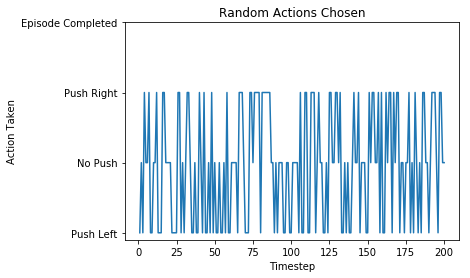

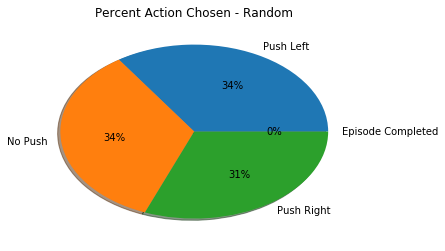

In [143]:
plot_actions(random_actions, ['random_actions1', 'random_actions2'], ['Random Actions Chosen', 'Percent Action Chosen - Random'])

These two graphs plot the state information - the car position and the car velocity. 

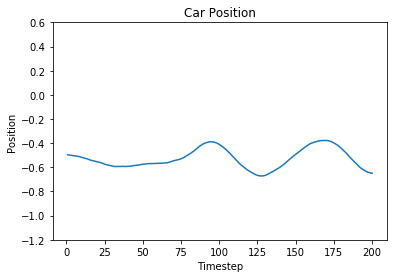

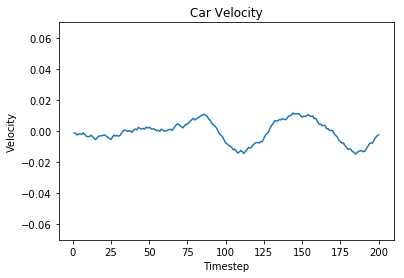

In [145]:
plot_states([random_position, random_velocity], 
            ['car_position_random', 'car_velocity_random'], 
            ['Car Position', 'Car Velocity'], 
            ['Position', 'Velocity'],
            [(-1.2, 0.6),(-0.07, 0.07)])

This graph plots the state information (position and velocity) on the same graph. As both position and velocity affect each other (moving downhill increases velocity / moving uphill decreases velocity and increased velocity allows the car to get up steeper slopes) it is helpful to see how these variables interact with each other. 

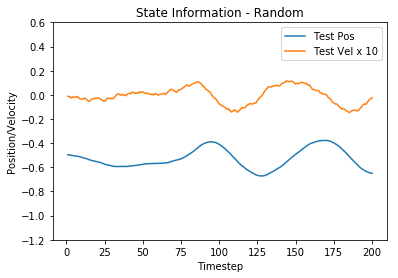

In [146]:
random_vel2 = [x*10 for x in random_velocity]
plot_states_comp([random_position, random_vel2], 
                 'state_comparison_random', 'State Information - Random', 'Position/Velocity', (-1.2, 0.6), ['Test Pos', 'Test Vel x 10'])

### Train / Test Algorithm
Creates new instance of model and experience replay, trains model, then tests model. Returns tuple of all rewards from training, last 100 training rewards, test rewards, test actions, and test state information. All parameters have defaults, run this function with named parameters to override. 

In [53]:
def upThatHill(lr=0.0005, h_size=256, buff_sz=85000, batch_sz=64, batch_freq=1, update_target_freq=2, gamma=0.99, random_eps=25, train_eps=5000, anneal_eps=75):
    a_size = 3 # Number of actions
    s_size = 2 # Number of state observations
    dqn = Agent(lr, h_size, s_size, a_size) # Initialize the agents
    myBuffer = Replay_Buffer(buff_sz) # Initialize action replay
    #Set epsilon decay 
    e = 1
    min_e = 0
    decay = (1 - min_e)/anneal_eps
    all_rewards = []
    avg_rewards = deque(maxlen=100) # Length of win condition
    max_reward = -200 # Starts at the lowest possible reward - for tracking new maximum rewards during training

    for i in range(train_eps):
        # Reset the environment for new episode
        actions = []
        s = env.reset()
        d = False
        ep_reward = 0
        
        # While this episode is not done
        while not d:
            
            # Choose action - either randomly (exploration) or by highest value (exploitation)
            if i < random_eps or np.random.rand(1) < e:
                a = np.random.randint(0, a_size)
            else: 
                a = dqn.getAction(s)
                
            # Take action and save experience to replay buffer
            actions.append(a)
            s1,r,d,_ = env.step(a)
            myBuffer.add((s,a,r,s1,d)) 

            # Update the target model if necessary
            if i % update_target_freq == 0: 
                dqn.updateTarget() 

            if i > random_eps:
                # Perform learning
                batch = myBuffer.sample(batch_sz)
                states = []
                actions = []
                rewards = []
                next_states = []
                dones = []
                for vals in batch:
                    states.append(vals[0])
                    actions.append(vals[1])
                    rewards.append(vals[2])
                    next_states.append(vals[3])
                    dones.append(vals[4])

                y = np.zeros((batch_sz, a_size))
                q = dqn.model.predict(np.array(states))
                q1 = dqn.target_model.predict(np.array(next_states))
                x = np.array(states)

                for k in range(batch_sz):
                    target = q[k]
                    target_action = rewards[k]
                    if not dones[k]:
                        target_action += (gamma * max(q1[k]))
                    target[actions[k]] = target_action
                    y[k, :] = target
                dqn.model.fit(x, y, batch_size=batch_sz, epochs=1, verbose=False)

            # Add reward to episode reward and make current state into previous state
            ep_reward += r
            s = s1

        # Decay exploration factor
        if i > random_eps and e > min_e: 
            e -= decay

        # Add rewards to running average and all rewards
        avg_rewards.append(ep_reward)
        all_rewards.append(ep_reward)
        
        # Report when a new best reward is found
        if ep_reward > max_reward:
            max_reward = ep_reward
            print("New max!", max_reward)
            
        # Go to test phase if agent has learned enough
        if sum(avg_rewards)/len(avg_rewards) > -105: 
            break
            
        #Periodically report on the model.
        if i % 200 == 0:
            print("Episode", i)
            print("Avg reward", sum(avg_rewards)/len(avg_rewards))
            
    print("Avg reward", sum(avg_rewards)/len(avg_rewards))
    print("Done training")
    print("Total episodes: ", i)
    
    test_rewards = []
    test_actions = []
    test_states = []
    for test in range(100): # Test trained model
        actions = []
        states = []
        s = env.reset()
        d = False
        ep_reward = 0
        while not d: 
            a = dqn.getAction(s)
            actions.append(a)
            states.append(s)
            s1,r,d,_ = env.step(a)
            ep_reward += r
            s = s1

        test_rewards.append(ep_reward)
        test_actions.append(actions)
        test_states.append(states)
    print("Test complete")
    print("Test result:", sum(test_rewards)/len(test_rewards))
    return all_rewards, avg_rewards, test_rewards, test_actions, test_states

# Training and Model Evaluation
## Baseline to beat: 1119
The best baseline model on [OpenAI for MountainCar](https://gym.openai.com/envs/MountainCar-v0/) is currently 1119 training episodes to solve the environment. I will make various changes to the hyperparameters until I am able to solve the environment with fewer training episodes than the baseline. 

First, I'll try the model with the 'default' parameters that I chose for the train/test algorithm. 

In [54]:
baseline = upThatHill()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 256)               768       
_________________________________________________________________
dense_66 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_67 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_68 (Dense)             (None, 3)                 771       
Total params: 133,123.0
Trainable params: 133,123
Non-trainable params: 0.0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 256)               768       
_________________________________________________________________


Next I'll try lowering the learning rate from 0.005 to 0.002.

In [55]:
lower_lr = upThatHill(lr=0.0002)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 256)               768       
_________________________________________________________________
dense_74 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_75 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_76 (Dense)             (None, 3)                 771       
Total params: 133,123.0
Trainable params: 133,123
Non-trainable params: 0.0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 256)               768       
_________________________________________________________________


Since lowering the learning rate improved the number of training episodes required I'll try lowering it from 0.0002 to 0.0001. 

In [56]:
low_lr = upThatHill(lr=0.0001)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 256)               768       
_________________________________________________________________
dense_82 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_83 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_84 (Dense)             (None, 3)                 771       
Total params: 133,123.0
Trainable params: 133,123
Non-trainable params: 0.0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 256)               768       
_________________________________________________________________


Lowering the learning rate reduced the number of episodes again, from 1467 to 1306. For the next iteration I'll reduce the learning rate from 0.0001 to 0.00005, and I'll also increase the batch size from the default of 64 to 128 to allow the model to train more previous experiences per step. 

In [58]:
low_lr_high_batchsz = upThatHill(lr=0.00005, batch_sz=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 256)               768       
_________________________________________________________________
dense_98 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_99 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_100 (Dense)            (None, 3)                 771       
Total params: 133,123.0
Trainable params: 133,123
Non-trainable params: 0.0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 256)               768       
_________________________________________________________________


This model successfully solved the environment in only 1080 training episodes as compared to the baseline model's 1119 training episodes. 

### Pickle Results
We can use pickle to load the results from this model if desired. 

In [66]:
import pickle

Save the successful model results below. Note - Only use this cell if a new model was saved under the variable low_lr_high_batchsz.

In [68]:
### Do NOT run this cell unless a new low_lr_high_batchsz model is trained 
#this was used to save
with open('low_lr_high_batchsz.pkl', 'wb') as f:
    pickle.dump(low_lr_high_batchsz, f)

Below are the results from the successful model - saved from another time this notebook was run. If you want to create the graphs without training a new model run the cell below. 

In [ ]:
# Run this line to load results from the successful model
with open('low_lr_high_batchsz.pkl', 'rb') as f:
    baseline = pickle.load(f)

### Create Successful Model Graphs
These two graphs show the actions chosen by the trained model on the episode with the best reward from the test results. The line graph depicts both the action taken and the order in which they are taken, which is very important for solving this environment. The pie chart shows the ratio of which actions were taken. Note that since the episode finished before the maximum allowable 200 timesteps several of the actions are listed as 'episode completed'. This isn't a true action, but it used for comparison with the random graphs. 

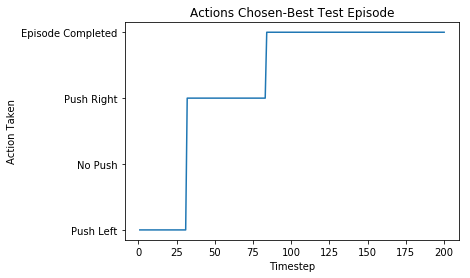

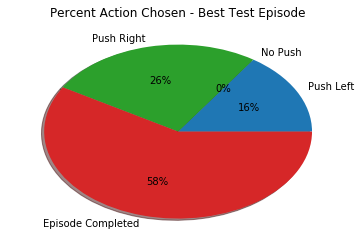

In [147]:
best = np.argmax(low_lr_high_batchsz[2])
plot_actions(low_lr_high_batchsz[3][best], ['test_actions_best1', 'test_actions_best2'], ['Actions Chosen-Best Test Episode', 'Percent Action Chosen - Best Test Episode'])

These two graphs plot the state information - the car position and the car velocity for the episode with the best reward from the test results.

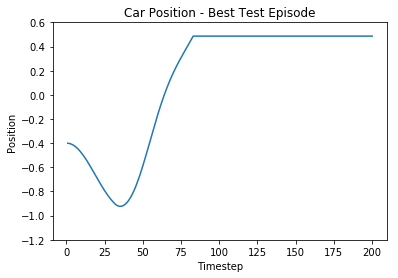

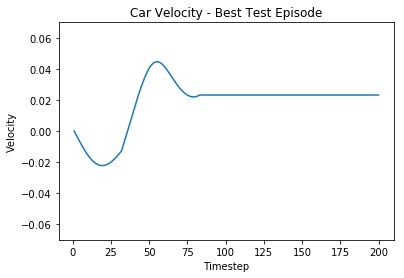

In [148]:
test_vel = [x[1] for x in low_lr_high_batchsz[4][best]]
test_pos = [x[0] for x in low_lr_high_batchsz[4][best]]

plot_states([test_pos, test_vel], 
            ['test_position', 'test_velocity'], 
            ['Car Position - Best Test Episode', 'Car Velocity - Best Test Episode'], 
            ['Position', 'Velocity'],
            [(-1.2, 0.6),(-0.07, 0.07)])

The next graph plots the state information (position and velocity) for the test episode with the best reward on the same graph. As both position and velocity affect each other (moving downhill increases velocity / moving uphill decreases velocity and increased velocity allows the car to get up steeper slopes) it is helpful to see how these variables interact with each other. Note that the velocity values have been scaled by 10. 

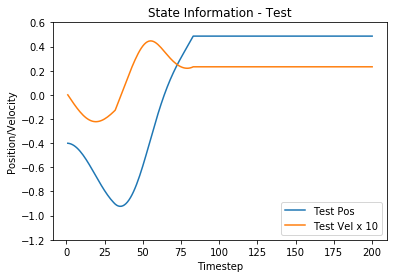

In [118]:
test_vel2 = [x*10 for x in test_vel]
plot_states_comp([test_pos, test_vel2], 
                 'state_comparison_test', 'State Information - Test', 'Position/Velocity', (-1.2, 0.6), ['Test Pos', 'Test Vel x 10'])

The next two graphs plot the state information (position and velocity) on the same graph. These graphs compare the data from the random model and the test episode with the best reward. Note the differences in the graphs - the test result ends very quickly and exhibits a wider range of values - indicating the model has learned compared to the very small fluctuations seen in the random results which isn't able to build up much momentum. 

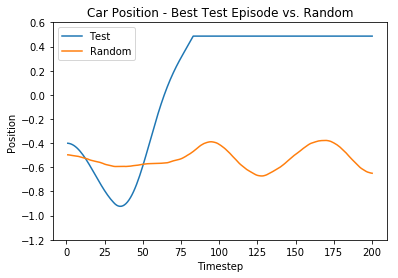

In [149]:
plot_states_comp([test_pos, random_position], 
                 'pos_comparison', 'Car Position - Best Test Episode vs. Random', 'Position', (-1.2, 0.6), ['Test', 'Random'])

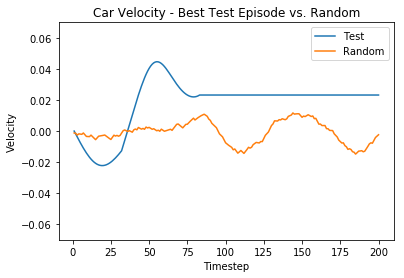

In [150]:
plot_states_comp([test_vel, random_velocity], 
                 'vel_comparison', 'Car Velocity - Best Test Episode vs. Random', 'Velocity', (-0.07, 0.07), ['Test', 'Random'])

The next graph plots the state information (velocity and position) for both the random data and the test episode with the best reward on the same graph. Note that the velocities have been scaled by 10. This is a combination of the two above graphs. 

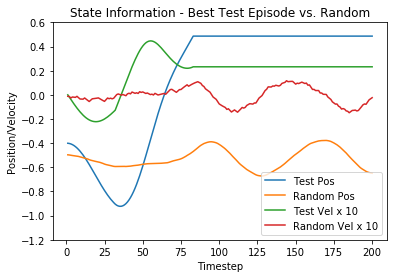

In [151]:
test_vel2 = [x*10 for x in test_vel]
random_vel2 = [x*10 for x in random_velocity]
plot_states_comp([test_pos, random_position, test_vel2, random_vel2], 
                 'state_comparison_both', 'State Information - Best Test Episode vs. Random', 'Position/Velocity', (-1.2, 0.6), ['Test Pos', 'Random Pos', 'Test Vel x 10', 'Random Vel x 10'])

This graph plots a histogram of the cumulative rewards over the 100 test episodes. It is interesting to note that while the majority of the results had rewards of less than -100, all of the test episodes successfully 'passed' the episode - they all ended before the maximum allowed timestep of 200 and furthermore, every episode had a reward better than the -110 average required to solve the environment. 

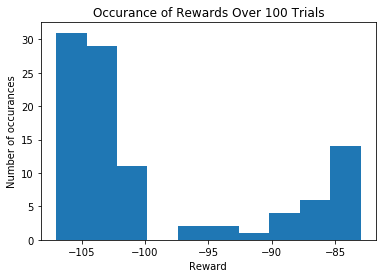

In [153]:
testHist(low_lr_high_batchsz[2], 'test_rewards_hist', 'Occurance of Rewards Over 100 Trials')

The final graphs depict the training rewards and testing rewards for the model. The first graph shows the training rewards for each episode throughout the training algorithm along with a rolling average of the last 10 rewards. The next graph focuses in on the last 100 episodes of the training data. This group of 100 episodes is the first time that the rolling average reward of 100 episodes breaks above -105, which is the stopping criteria for the training procedure. The final graph depicts the rewards for the 100 episodes of the test along with a line depicting the overall average for this test. 

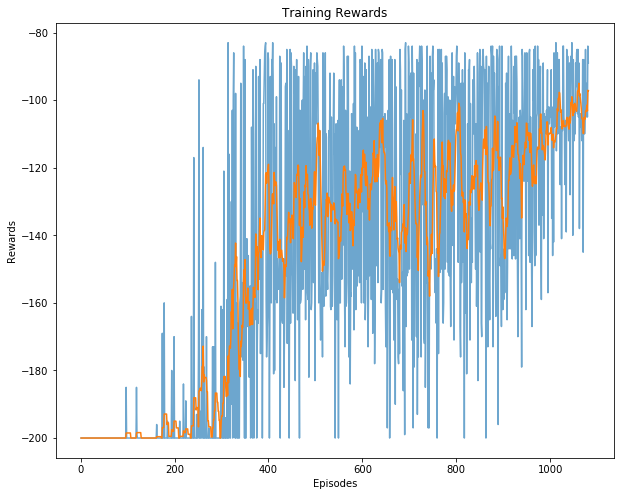

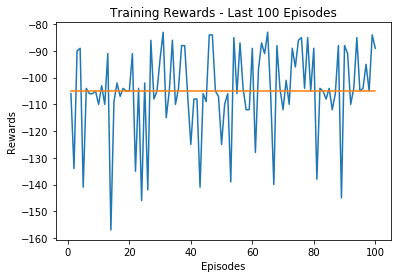

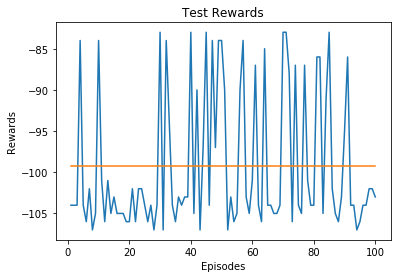

In [156]:
makeRewardPlots([low_lr_high_batchsz[0], low_lr_high_batchsz[1], low_lr_high_batchsz[2]], 
                ['train_rewards', 'avg_train_rewards', 'test_rewards'], 
                ['Training Rewards', 'Training Rewards - Last 100 Episodes', 'Test Rewards'])

In [161]:
!pip freeze

anaconda-client==1.6.3
appnope==0.1.0
bleach==1.5.0
clyent==1.2.2
cvxopt==1.1.9
decorator==4.0.11
entrypoints==0.2.2
html5lib==0.999
ipykernel==4.6.1
ipython==6.0.0
ipython-genutils==0.2.0
ipywidgets==6.0.0
jedi==0.10.2
Jinja2==2.9.6
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==5.0.1
jupyter-console==5.1.0
jupyter-core==4.3.0
MarkupSafe==0.23
mistune==0.7.4
nb-anacondacloud==1.2.0
nb-conda==2.0.0
nb-conda-kernels==2.0.0
nbconvert==5.1.1
nbformat==4.3.0
nbpresent==3.0.2
notebook==5.0.0
pandocfilters==1.4.1
pexpect==4.2.1
pickleshare==0.7.4
prompt-toolkit==1.0.14
ptyprocess==0.5.1
Pygments==2.2.0
python-dateutil==2.6.0
pytz==2017.2
PyYAML==3.12
pyzmq==16.0.2
qtconsole==4.3.0
requests==2.14.2
simplegeneric==0.8.1
six==1.10.0
terminado==0.6
testpath==0.3
tornado==4.5.1
traitlets==4.3.2
wcwidth==0.1.7
widgetsnbextension==2.0.0
